# Movie Review Classifer

Ian Kollipara

2022.03.27

CS 392 Seminar in Data Science

## Importing Packages

In [36]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import nltk
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, train_test_split, cross_val_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ikollipara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ikollipara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ikollipara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Preprocessing
### Data Exploration

In [2]:
df = pd.read_csv("movie.csv")
print(df.shape)
df.head(5)

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


This dataset is of movie reviews, with the goal of classifying reviews as positive or negative, given the review. Our dataset here contains 40,000 reviews - noted as the column `text` - as well as the type of review: Positive (1) or Negative (0) - denoted `label`. A good addition is a third column, length. This is the length of the text.

In [3]:
df['length'] = df['text'].map(lambda text: len(text))

From here we can visualize the distribution of Negative and Positive Reviews.

Text(0.5, 0, 'Classification')

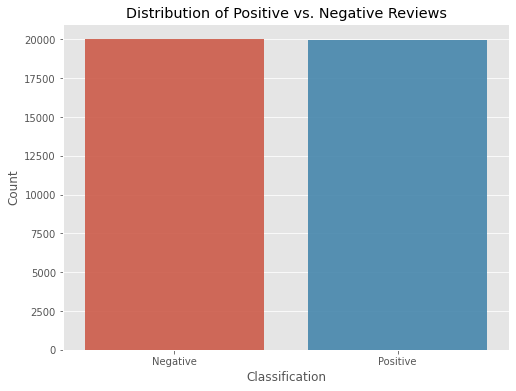

In [4]:
values = df["label"].value_counts().values
plt.figure(figsize=(8, 6))
sns.barplot(x=["Negative", "Positive"], y=values, alpha=0.9)

plt.title("Distribution of Positive vs. Negative Reviews")
plt.ylabel("Count")
plt.xlabel("Classification")

In [5]:
df.groupby("label").count()

,text,length
label,,
0,20019,20019
1,19981,19981


Our distribution is roughly equal, with ~20,000 in each. This makes for great data in terms of analysis, as there isn't any lopsided-ness to it. Next, we can investigate the metrics associated with the length of the text.

In [6]:
df.groupby("label")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,20019.0,1292.536990,942.220087,32.0,705.0,973.0,1571.0,8969.0
1,19981.0,1328.083279,1032.236721,65.0,690.0,972.0,1621.0,13704.0


From here, we can see most reviews are in the range of ~300 to ~2,300 words. However, both have reviews that are far past this. Given this, we can analyze the distribution of length in relation to the classification of the reviews.

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

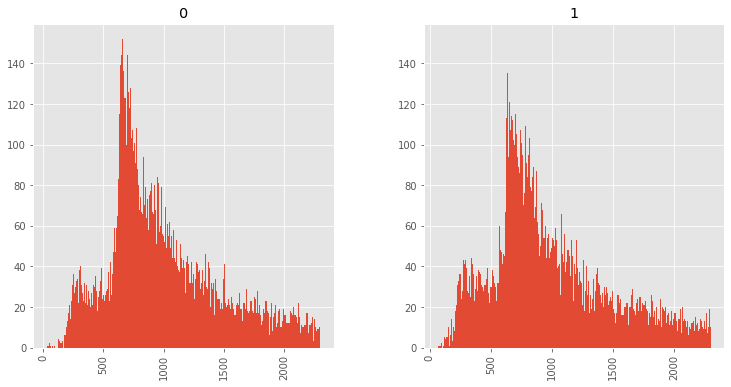

In [7]:
threshold = 2300
df[df["length"] < threshold].hist("length", by="label", bins=500, figsize=(12, 6))

From this, we can see a majority of the reviews, both for positive and negative, lie with in the range 500 to 1250. We can zoom in more, but what I want to see is the correlation between long reviews and their classification.

,text,length
label,,
0,2398,2398
1,2739,2739


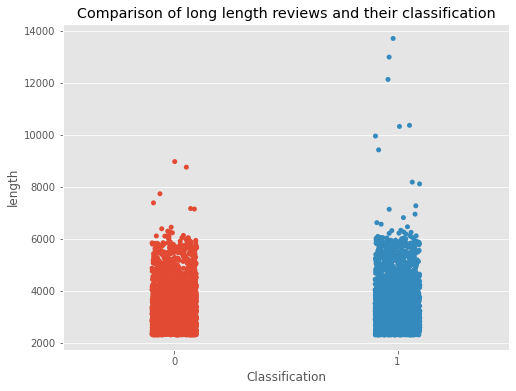

In [8]:
plt.figure(figsize=(8, 6))
sns.stripplot(y="length", x="label", data=df[df["length"] > threshold])
plt.title("Comparison of long length reviews and their classification")
plt.xlabel("Classification")
df[df["length"] > threshold].groupby("label").count()

It appears that, by a small margin, longer reviews are positive. We can analyze the correlation as well.

In [9]:
print(df[df["length"] > threshold].corr())
print()
print(df[df["length"] > threshold].corr("spearman"))

           label    length
label   1.000000  0.044712
length  0.044712  1.000000

           label    length
label   1.000000  0.044789
length  0.044789  1.000000


As I thought, longer length reviews are somewhat positively correlated with Positive Classification (1). 

### Feature Extraction
#### Removing Punctuation

A key piece to remove from the document before running it through a Lemmatizer and Stop Word Remover, is the removal of punctuation. These marks hold no meaning in terms of classification. Thus it makes sense to remove them. I chose to do this before the lemmatizer as - seen through experiementation - punctuation can cause words that are not real to appear, such as "wa n't" instead of "wasnt".

In [10]:
# sourced from https://www.geeksforgeeks.org/python-remove-punctuation-from-string/

df['text'] = df['text'].apply(lambda text: re.sub(r'[^\w\s]|\d', ' ', text))
df

,text,label,length
0,I grew up b watching and loving the Th...,0,874
1,When I put this movie in my DVD player and sa...,0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983
...,...,...,...
39995,Western Union is something of a forgotten cl...,1,3111
39996,This movie is an incredible piece of work It ...,1,291
39997,My wife and I watched this movie because we pl...,0,1092
39998,When I first watched Flatliners I was amazed ...,1,1045


#### Lemmatizing

The first step in preprocessing this dataframe is stemming the words. This is accomplished through a few different means. the way I chose is to do lemmatization. The main goal of this is to break a word down to its root. This process is vital, as it limits our features by removing plurals and such. 

The lemmatizer I chose comes from [Princeton's WordNet](https://wordnet.princeton.edu/). It does a wonderful job of lemmatizing synonyms as it tries to detect them. 

In [11]:
lemmatizer = WordNetLemmatizer()

In [ ]:
%%time

df['lemmatized_text'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

CPU times: user 39.6 s, sys: 64.9 ms, total: 39.6 s
Wall time: 39.9 s


To show this nearly 3 minute process wasn't a complete waste, here is an example review before and after.

In [ ]:
print(f"""
Before Lemmatization:
{df['text'][171]}

After Lemmatization:
{df['lemmatized_text'][171]}
""")


Before Lemmatization:
I have to say although this movie was formulaic throughout with a plot stolen from films like Friday the   th I Know What You Did Last Summer  this movie wasn t that bad  In fact it wasn t as bad as most of the Horror films Hollywood has released recently  The killings although at times a little too imaginative were in most instances just that  original  The cast was mediocre which is to be expected from low budget features but much better than what that much bigger studio Artisan Lions Gate has been offering  My only real complaint that wasn t due to the film s budget  which must have been small  was the contrived  twist  ending  I m sorry but this is what put this film in the bad category for me  The ending was just stupid and tacked on  Before that I was a little bored  but actually enjoying it      

After Lemmatization:
i have to say although this movie wa formulaic throughout with a plot stolen from film like friday the th i know what you did last summer th

From here we can already see a drastic difference in the sentence. The meaning is parsable, but we've broken many words down.
#### Stop Word Removal

The next step in feature extraction is removing Stop Words. Stop Words are defined as words that hold no meaning in relation to the classifier. In our case, these are words that don't carry a positive or negative value in connection the reviews. I found a list of stop words at https://github.com/rashmishrm/Movie-Reviews-Classification/blob/master/stop-words.txt, and I made a few edits as well. From here we can plug this into a vectorizer, which will remove the stop words.

In [30]:
with open("stop-words.txt") as f:
    stop_words = [lemmatizer.lemmatize(w[:-1]) for w in f]

## Classification
### Setting Up the Pipeline
#### Creating our Test and Train Set

We can create our test-train split on our data from here.

In [31]:
X = np.asarray(df['lemmatized_text'])
y = np.asarray(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Vectorization

As the words on their own carry no inherent meaning, a vectorizer is used to determine a numerical value. The two classifiers created here are Binary and Count.

Binary Word Vectors are vectors where if the word appeared is tracked, while in Count Vectors the amount - or rather "count" - of the word is kept.

### Bernoulli Naive Bayes

Given all that, we can construct a Pipeline based around the BernoulliNB Algorithm. This algorithm based on the Naive Bayes Assumption assumes all events are independent. Scores are also affected by the lack of a feature. These two traits define a Bernoulli Naive Bayes.

In [32]:
bernoulliNB_Binary = Pipeline([
    ("vect", CountVectorizer()),
    ("clf", BernoulliNB())
])

#### Hyperparameter Tuning

To test a variety of parameters, we can construct a parameter grid to pass to `GridSearchCV`. This will test all the combinations present, and provide the best model based off a specific metric. 

In [38]:
%%time

param_grid = {
    'vect__binary': [True, False],
    'vect__stop_words': [stop_words, 'english', None],
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)],
    'clf__alpha': [0.1, 1, 1.5, 2.0]
}

clf_bernoulli_grid = GridSearchCV(bernoulliNB_Binary, param_grid, scoring='f1', n_jobs=-1, verbose=1).fit(X_train, y_train)


print(f"Best Score: {clf_bernoulli_grid.best_score_}")

print(f"Optimal Values: {clf_bernoulli_grid.best_params_}\n")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Score: 0.8777878027182837
Optimal Values: {'clf__alpha': 0.1, 'vect__binary': True, 'vect__ngram_range': (2, 3), 'vect__stop_words': None}

CPU times: user 36.3 s, sys: 19.3 s, total: 55.5 s
Wall time: 19min 56s


From this we can now craft our ideal model.

#### Ideal Model

In [93]:
%%time

ideal_bernoulli_binary = Pipeline([
    ("vect", CountVectorizer(binary=True, stop_words=None, strip_accents='ascii', ngram_range=(1,2))),
    ("clf", BernoulliNB(alpha=0.1))
])

ideal_bernoulli_binary.fit(X_train, y_train)

y_pred = ideal_bernoulli_binary.predict(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
print()
print(f"Cross Val Score: {cross_val_score(ideal_bernoulli_binary, X, y, n_jobs=-1)}")

Confusion Matrix
[[4507  482]
 [ 696 4315]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88      4989
    Positive       0.90      0.86      0.88      5011

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Cross Val Score: [0.881375 0.8855   0.885375 0.8805   0.886   ]
CPU times: user 12 s, sys: 221 ms, total: 12.2 s
Wall time: 30.4 s


From this we see that BernoulliNB is strong, but not perfect. From here we can move to our next model, MultinomialNB.

### Multinomial Naive Bayes 

In [ ]:
multinomial_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("clf", MultinomialNB())
])

In [ ]:
%%time


param_grid = {
    'vect__binary': [True, False],
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'vect__strip_accents': ['ascii', 'unicode', None],
    'vect__stop_words': [stop_words, 'english', None],
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__alpha': [0.1, 0.5, 1]
}

clf_multinomial_pipeline = HalvingGridSearchCV(multinomial_pipeline, param_grid, scoring='f1', n_jobs=-1, verbose=1, factor=2).fit(X_train, y_train)

print(f"Best Score: {clf_multinomial_pipeline.best_score_}")

print(f"Optimal Values: {clf_multinomial_pipeline.best_params_}\n")

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 234
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 243
n_resources: 234
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------
iter: 1
n_candidates: 122
n_resources: 468
Fitting 5 folds for each of 122 candidates, totalling 610 fits
----------
iter: 2
n_candidates: 61
n_resources: 936
Fitting 5 folds for each of 61 candidates, totalling 305 fits
----------
iter: 3
n_candidates: 31
n_resources: 1872
Fitting 5 folds for each of 31 candidates, totalling 155 fits
----------
iter: 4
n_candidates: 16
n_resources: 3744
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 5
n_candidates: 8
n_resources: 7488
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 4
n_resources: 14976
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 7
n_candidates: 2
n_resourc